# HangiKredi Case Study: Term Deposit Marketing
## 1- Classification using XGBoost

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder

In [2]:
df = pd.read_csv('/home/saif/Documents/term-deposit-marketing-2020.csv')

In [3]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

No missing values

In [4]:
# Encode categorical columns to numbers

# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
# Instantiate encoder
enc = OrdinalEncoder()
# Encode
df[categorical_cols] = enc.fit_transform(df[categorical_cols]).astype('int64')

Display information about the dataset:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        40000 non-null  int64
 1   job        40000 non-null  int64
 2   marital    40000 non-null  int64
 3   education  40000 non-null  int64
 4   default    40000 non-null  int64
 5   balance    40000 non-null  int64
 6   housing    40000 non-null  int64
 7   loan       40000 non-null  int64
 8   contact    40000 non-null  int64
 9   day        40000 non-null  int64
 10  month      40000 non-null  int64
 11  duration   40000 non-null  int64
 12  campaign   40000 non-null  int64
 13  y          40000 non-null  int64
dtypes: int64(14)
memory usage: 4.3 MB


In [6]:
df.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,4.266050,1.154100,1.199950,0.020225,1274.277550,0.600775,0.173250,0.696275,16.017225,5.509525,254.824300,2.882175,0.072400
std,9.641776,3.291229,0.605485,0.741643,0.140771,2903.769716,0.489745,0.378468,0.921817,8.278127,2.909522,259.366498,3.239051,0.259152
min,19.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,33.000000,1.000000,1.000000,1.000000,0.000000,54.000000,0.000000,0.000000,0.000000,8.000000,3.000000,100.000000,1.000000,0.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,407.000000,1.000000,0.000000,0.000000,17.000000,6.000000,175.000000,2.000000,0.000000
75%,48.000000,7.000000,2.000000,2.000000,0.000000,1319.000000,1.000000,0.000000,2.000000,21.000000,8.000000,313.000000,3.000000,0.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,10.000000,4918.000000,63.000000,1.000000


In [7]:
# Generate Folds
KF = KFold(n_splits = 5, shuffle = True, random_state=1)

# XGBoost parameters
param = {}
param['objective'] = 'binary:logistic'

In [8]:
accs = [] # to store the accuracies of each fold
evals = [] # to store evaluation details of each fold
print('')
for i,(train_ind, test_ind) in enumerate(KF.split(df)):
    print('======== Fold',i,'========\n')
    # Train test split
    X_train, X_test, y_train, y_test = df.iloc[train_ind, :-1], df.iloc[test_ind, :-1], df.iloc[train_ind, -1], df.iloc[test_ind, -1]
    # Ratio to scale positive instances because of imbalance
    ratio = (len(y_train)-sum(y_train))/sum(y_train)
    param['scale_pos_weight'] = ratio
    # Convert to XGBoost matrices 
    xtrn = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
    xtst = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.columns)
    # to be able to see the training progress of each fold
    watchlist = [(xtrn, 'train'), (xtst, 'test')]
    evals_result = {}
    # Train
    model = xgb.train(param, xtrn, 747, evals=watchlist, evals_result=evals_result, verbose_eval=False) 
    evals.append(evals_result)
    pred = model.predict(xtst)
    pred = pred > 0.5
    # Report
    acc = accuracy_score(y_test, pred)
    accs.append(acc)
    print('Accuracy: {:.1f}%\n'.format(acc*100))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, pred), '\n')
    print('Classification Report:')
    print(classification_report(y_test, pred))
print('========================\n')
print('Average Accuracy: {:.1f}%\n\n************************'.format((sum(accs)/len(accs))*100))


======== Fold 0 ========

Accuracy: 93.5%

Confusion Matrix:
[[7163  272]
 [ 252  313]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7435
           1       0.54      0.55      0.54       565

    accuracy                           0.93      8000
   macro avg       0.75      0.76      0.75      8000
weighted avg       0.94      0.93      0.94      8000

======== Fold 1 ========

Accuracy: 93.2%

Confusion Matrix:
[[7151  293]
 [ 254  302]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7444
           1       0.51      0.54      0.52       556

    accuracy                           0.93      8000
   macro avg       0.74      0.75      0.74      8000
weighted avg       0.93      0.93      0.93      8000

======== Fold 2 ========

Accuracy: 93.0%

Confusion Matrix:
[[7094  308]
 [ 252  346]] 

Classification Report:
      

We see that an accuracy of 93% can be achieved on this dataset, and that classifying the positive label correctly is more difficult than classifying the negative label.
## 2- Customers who are more likely to buy the investment product

In [10]:
# Segment customers into three segments based on each numerical feature
numerical_features = ['age', 'balance', 'duration', 'campaign']
for feature in numerical_features:
    sorted_inds = df[feature].argsort()
    df[feature] = 2
    df[feature][sorted_inds[:2*(len(df)//3)]] = 1
    df[feature][sorted_inds[:len(df)//3]] = 0

In [11]:
df.y.groupby(df['age']).mean()

age
0    0.085352
1    0.065252
2    0.066597
Name: y, dtype: float64

Younger customers have a higher tendency to buy

In [12]:
df.y.groupby(df['balance']).mean()

balance
0    0.055876
1    0.070352
2    0.090970
Name: y, dtype: float64

Customers with a higher balance have a higher tendency to buy

In [13]:
df.y.groupby(df['duration']).mean()

duration
0    0.008175
1    0.027751
2    0.181266
Name: y, dtype: float64

Customers with whom last contact duration was long have a **significantly** higher probability of buying

In [14]:
df.y.groupby(df['campaign']).mean()

campaign
0    0.092252
1    0.065102
2    0.059847
Name: y, dtype: float64

Customers with a **lower** number of times contacted have a higher tendency to buy

In [15]:
df.y.groupby(df['loan']).mean()

loan
0    0.076081
1    0.054834
Name: y, dtype: float64

Customers who don't have a personal loan have a higher tendency to buy

In [16]:
df.y.groupby(df['default']).mean()

default
0    0.072644
1    0.060569
Name: y, dtype: float64

Customers who don't have a credit on default have a higher tendency to buy

In [17]:
df.y.groupby(df['housing']).mean()

housing
0    0.089674
1    0.060921
Name: y, dtype: float64

Customers who don't have a housing loan have a higher tendency to buy

In [18]:
df2 = pd.DataFrame(enc.inverse_transform(df[categorical_cols]), columns=categorical_cols)
df2.y = df.y

In [19]:
df2.y.groupby(df2['education']).mean().sort_values(ascending=False)

education
tertiary     0.091826
secondary    0.067546
unknown      0.062704
primary      0.056300
Name: y, dtype: float64

Customers with tertiary education have a higher tendency to buy

In [20]:
df2.y.groupby(df2['job']).mean().sort_values(ascending=False)

job
student          0.156489
retired          0.105080
unemployed       0.086957
management       0.082782
self-employed    0.079208
admin            0.078296
technician       0.072534
unknown          0.072340
entrepreneur     0.062633
services         0.060870
blue-collar      0.057018
housemaid        0.048758
Name: y, dtype: float64

Students and retired customers have a higher tendency to buy

In [21]:
df2.y.groupby(df2['marital']).mean().sort_values(ascending=False)

marital
single      0.094315
divorced    0.082751
married     0.060609
Name: y, dtype: float64

Single customers have a higher tendency to buy

In [22]:
df2.y.groupby(df2['contact']).mean().sort_values(ascending=False)

contact
cellular     0.089628
telephone    0.071521
unknown      0.038935
Name: y, dtype: float64

Customers contacted through cellphone have a higher tendency to buy

## 3- Most important features

In [23]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

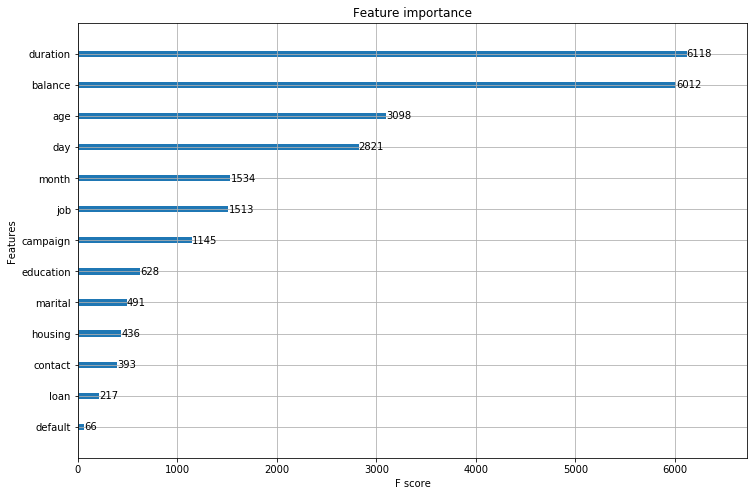

In [24]:
xgb.plot_importance(model)

We see that the last contact duration and the average yearly balance are more important in determining whether a client will subscribe to a term deposit.